In [85]:
import gymnasium as gym
import gymnasium_2048 
import pandas as pd
import numpy as np
from tqdm import trange, tqdm
import pickle 
from pathlib import Path
from pysr import PySRRegressor
import pysindy as ps
from pysindy.feature_library import CustomLibrary, ConcatLibrary, PolynomialLibrary
from pysindy.optimizers import FROLS
from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
import sympy as sp
import pysindy as ps
import joblib
import sys
sys.path.append('..')

from simulations.interpretable_agents import FormulaAgent, ESPLLearner
from simulations.vizualize_grid import get_tile_value
from simulations.run import run_episode, preprocess_dataset
from simulations.features import extract_features
from simulations.base_agents import NNAgent

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ENV_ID = "gymnasium_2048/TwentyFortyEight-v0"

In [ ]:
env = gym.make(ENV_ID)
base_agent = NNAgent(env)
base_agent.load_weights('../data/weights_ep5000.pth')
base_agent.model.eval()

Net(
  (conv1): Conv2d(16, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
)

In [4]:
features_narrow = [
    'snake_weighted_sum',            
    'monotonicity',   
    'tile_sum',    
    'potential_merges', 
    'corner_weighted_sum',
    'num_empty',
    'max_tile',
    'smoothness',
    'corner_sum',
    'second_max_tile',
    'edge_occupancy',   
    'conv_vert_gradient', 
    'conv_horiz_gradient',
    'entropy'  
]

In [ ]:
# загрузка сырых данных без предобработки
with open("../data/nn_expert_dataset.pkl", "rb") as f:
    data = pickle.load(f)
data.keys()

dict_keys(['boards', 'features', 'actions', 'rewards', 'episode_ids', 'step_ids', 'Q-values'])

In [ ]:
# загрузка данных по 100 лучшим партиям без расширения
features_width, target_width = preprocess_dataset(
    "../data/nn_expert_dataset.pkl", 
    keep_best=100, 
    features_list=features_narrow, 
    expand=False, 
    normalize=True
)

In [ ]:
# загрузка данных по 100 лучшим партиям с разделением по уровням без расширения
(
    (features_easy_width, target_easy_width), 
    (features_medium_width, target_medium_width), 
    (features_hard_width, target_hard_width)
) = preprocess_dataset(
    "../data/nn_expert_dataset.pkl", 
    keep_best=100, 
    features_list=features_narrow, 
    expand=False, 
    transform='divide_by_empty',
    normalize=True
)

In [ ]:
# загрузка данных по 100 лучшим партиям с расширением
with open("../data/nn_expert_dataset_expanded.pkl", "rb") as f:
    data_expanded = pickle.load(f)
features_expanded, target_expanded = data_expanded['features'], data_expanded['target']

In [ ]:
with open("../data/nn_expert_dataset_expanded_level.pkl", "rb") as f:
    data_expanded_level = pickle.load(f)
    
(
    features_expanded_easy, 
    target_expanded_easy, 
    features_expanded_medium, 
    target_expanded_medium,
    features_expanded_hard, 
    target_expanded_hard,  
) = (
    data_expanded_level['features_easy'], 
    data_expanded_level['target_easy'], 
    data_expanded_level['features_medium'], 
    data_expanded_level['target_medium'], 
    data_expanded_level['features_hard'], 
    data_expanded_level['target_hard'], 
)

## ESPL agent

In [82]:
env = gym.make(ENV_ID)
learner = ESPLLearner(
    env,
    layers=6,
    lr=2e-4,
    batch_size=256,
    warmup_steps=1_000,
    updates_per_step=1,
    anneal_start=50_000,
    verbose=True,
    seed=42,
    feature_list=features_narrow
)
learner.train_episodes(500)
expr = learner.export_formula()
print("Learned formula:", expr)

Ep     1  reward=1580.0  env=    161  grad=      0  eps=0.6965  T=5.00
Ep     2  reward= 812.0  env=    266  grad=      0  eps=0.6930  T=5.00
Ep     3  reward=1552.0  env=    427  grad=      0  eps=0.6896  T=5.00
Ep     4  reward=1048.0  env=    554  grad=      0  eps=0.6861  T=5.00
Ep     5  reward=1296.0  env=    691  grad=      0  eps=0.6827  T=5.00
Ep     6  reward=1280.0  env=    828  grad=      0  eps=0.6793  T=5.00
Ep     7  reward=1184.0  env=    958  grad=      0  eps=0.6759  T=5.00
Ep     8  reward=1368.0  env=   1099  grad=    100  eps=0.6725  T=5.00
Ep     9  reward= 796.0  env=   1200  grad=    201  eps=0.6691  T=5.00
Ep    10  reward=2888.0  env=   1432  grad=    433  eps=0.6658  T=5.00
Ep    11  reward=1420.0  env=   1582  grad=    583  eps=0.6624  T=5.00
Ep    12  reward= 924.0  env=   1695  grad=    696  eps=0.6591  T=5.00
Ep    13  reward=1664.0  env=   1864  grad=    865  eps=0.6558  T=5.00
Ep    14  reward=1216.0  env=   1996  grad=    997  eps=0.6526  T=5.00
Ep    

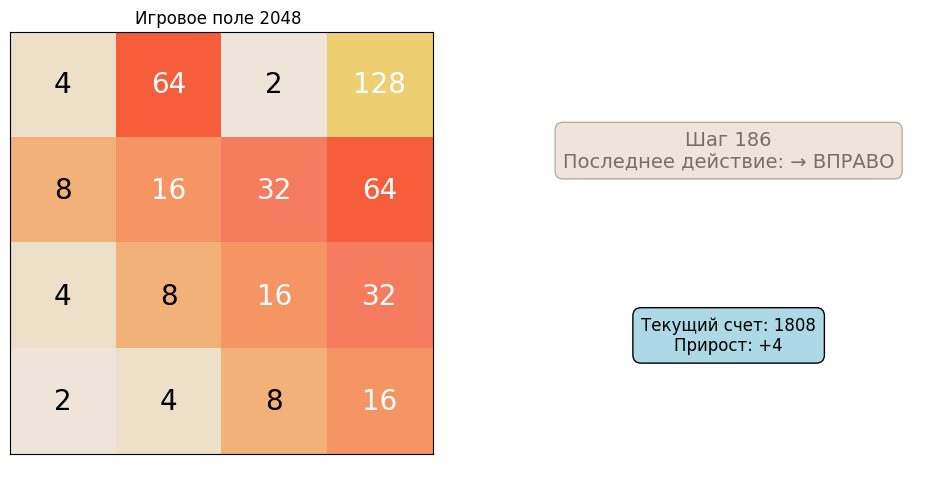


===== Финал =====
Игра завершена (ходов сыграно: 187)
Итоговый счёт: 1808


100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


2462.88


In [84]:
env = gym.make(ENV_ID)
    
def my_formula(f: dict, action: int) -> float:
    r, n = f.raw, f.norm    
    return (
        1.567 * r["monotonicity"] +      # f1
        0.883 * r["edge_occupancy"] +    # f10
        0.993                            # 0.606 + 0.387
    )

agent = FormulaAgent(env, formula=my_formula, feature_list=features_narrow)
score = run_episode(env,agent)

scores = []
for _ in tqdm(range(100)):
    agent = FormulaAgent(env, formula=my_formula, feature_list=features_narrow)
    score = run_episode(env, agent, visualize=False)
    scores.append(score)
    
print(np.mean(scores))

## Sparse regression

In [79]:
def add(x, y):
    x, y = np.array(x), np.array(y)
    return x + y

def sub(x, y):
    x, y = np.array(x), np.array(y)
    return x - y

def mul(x, y):
    x, y = np.array(x), np.array(y)
    return x * y

def div(x, y):
    x_arr, y_arr = np.array(x), np.array(y)
    # делим, ставим 0 там, где делитель равен нулю
    result = x_arr / y_arr
    result[y_arr == 0] = 0.0
    return result

def maximum(x, y):
    x, y = np.array(x), np.array(y)
    return np.maximum(x, y)

def minimum(x, y):
    x, y = np.array(x), np.array(y)
    return np.minimum(x, y)

def cond(x, y, z):
    x_arr, y_arr, z_arr = np.array(x), np.array(y), np.array(z)
    return np.where(x_arr >= 0, y_arr, z_arr)

def abs_fn(x):
    return np.abs(np.array(x))

def neg_fn(x):
    return -np.array(x)

### обучение отдельно для трех ситуаций по сложности на доске (easy, medium, hard)

In [82]:
binary_funcs = [add, sub, mul, div, maximum, minimum]
binary_names = [
    lambda n1, n2: f"({n1}+{n2})",
    lambda n1, n2: f"({n1}-{n2})",
    lambda n1, n2: f"({n1}*{n2})",
    lambda n1, n2: f"({n1}/{n2})",
    lambda n1, n2: f"max({n1},{n2})",
    lambda n1, n2: f"min({n1},{n2})",
]
unary_funcs = [abs_fn, neg_fn]
unary_names = [
    lambda n: f"abs({n})",
    lambda n: f"-{n}",
]

# Библиотека бинарных функций без диагоналей
lib_binary = CustomLibrary(
    library_functions=binary_funcs,
    function_names=binary_names,
    interaction_only=True,    # ← только i<j, без (i,i)
    include_bias=False
)
# Библиотека унарных (работает на каждом признаке отдельно)
lib_unary = CustomLibrary(
    library_functions=unary_funcs,
    function_names=unary_names,
    interaction_only=True,    # для унарных имеет значение меньшее, но безопасно
    include_bias=False
)
# Условная функция cond(x,y,z) — комбинации по тройкам i<j<k
lib_cond = CustomLibrary(
    library_functions=[cond],
    function_names=[lambda n1, n2, n3: f"cond({n1},{n2},{n3})"],
    interaction_only=True,
    include_bias=False
)
# Полиномы первой степени (линейные признаки)
poly1 = PolynomialLibrary(degree=1, include_bias=True)

# Составляем финальную библиотеку
feature_lib = ConcatLibrary([poly1, lib_unary, lib_binary, lib_cond])
optimiser = FROLS(max_iter=4, alpha=0.01)
models = []

level_dataset = {
    'easy':   (features_expanded_easy,   target_expanded_easy),
    'medium': (features_expanded_medium, target_expanded_medium),
    'hard':   (features_expanded_hard,   target_expanded_hard),
}

for key, (X, y) in level_dataset.items():
    model = ps.SINDy(
        feature_library=feature_lib,
        optimizer=optimiser,
        feature_names=[n.replace(' ', '_') for n in features_narrow],
    )
    model.fit(X, x_dot=y)
    print(f"\n=== Уравнение для уровня {key} ===")
    model.print(f"Q_{key}")
    models.append(model)


=== Уравнение для уровня easy ===
Q = 1449.031 1 + 19.832 (conv_vert_gradient+entropy) + -51.438 cond(tile_sum,num_empty,smoothness) + 35.630 cond(max_tile,edge_occupancy,conv_vert_gradient)

=== Уравнение для уровня medium ===
Q = 1455.831 1 + -34.923 (max_tile-conv_vert_gradient) + -93.414 cond(tile_sum,num_empty,max_tile) + 113.093 cond(tile_sum,smoothness,entropy)

=== Уравнение для уровня hard ===
Q = 1564.325 1 + 87.273 (edge_occupancy*conv_vert_gradient) + 138.724 cond(tile_sum,num_empty,entropy) + 191.593 cond(max_tile,smoothness,edge_occupancy)


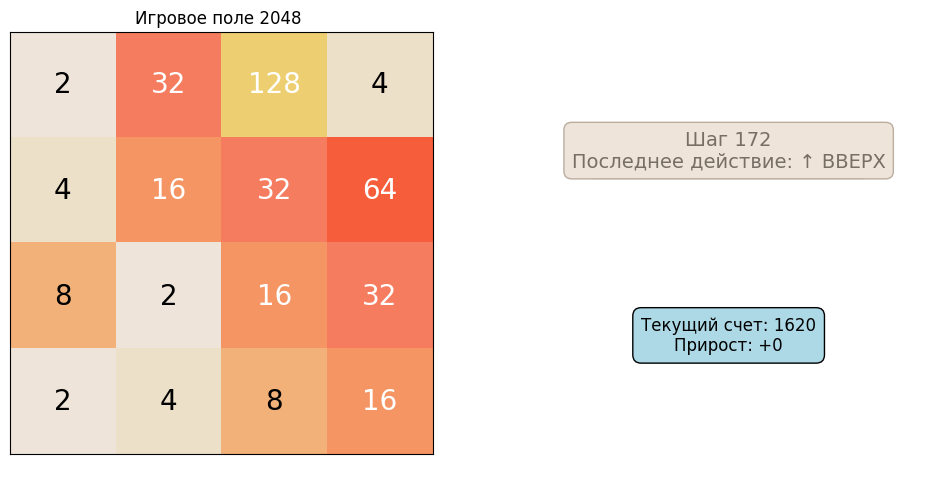


===== Финал =====
Игра завершена (ходов сыграно: 173)
Итоговый счёт: 1620


100%|██████████| 100/100 [00:42<00:00,  2.36it/s]


2455.0


In [ ]:
env = gym.make(ENV_ID)
def my_formula(f: dict, action: int):
    r, n = f.raw, f.norm    
    if r['num_empty'] >= 8:
        to_add1 = n['num_empty'] if n['tile_sum'] >= 0 else n['smoothness']
        to_add2 = n['edge_occupancy'] if n['max_tile'] >= 0 else n['conv_vert_gradient']
        return (
            1449.031
            + 19.832 * (n['conv_vert_gradient'] + n['entropy']) 
            - 51.438 * to_add1 
            + 35.630 * to_add2

        )
    elif r['num_empty'] < 8 and r['num_empty'] >= 4:
        to_add1 = n['num_empty'] if n['tile_sum'] >= 0 else n['max_tile']
        to_add2 = n['smoothness'] if n['tile_sum'] >= 0 else n['entropy']
        return (
            1455.831 
            - 34.923 * (n['max_tile'] - n['conv_vert_gradient']) 
            - 93.414 * to_add1 
            + 113.093 * to_add2
        )
    elif r['num_empty'] < 4:
        to_add1 = n['num_empty'] if n['tile_sum'] >= 0 else n['entropy']
        to_add2 = n['smoothness'] if n['max_tile'] >= 0 else n['edge_occupancy']
        return (
            1564.325
            + 87.273 * (n['edge_occupancy'] * n['conv_vert_gradient']) 
            + 138.724 * to_add1 
            + 191.593 * to_add2
        )

agent = FormulaAgent(
    env,
    feature_list=features_narrow,
    formula=my_formula,
    data=features_expanded
)
run_episode(env, agent)

scores = []
for _ in tqdm(range(100)):
    agent = FormulaAgent(env, formula=my_formula, data=features_expanded, feature_list=features_narrow)
    score = run_episode(env, agent, visualize=False)
    scores.append(score)
    
print(np.mean(scores))

### многоклассовый подход

In [86]:
binary_funcs = [add, sub, mul, div, maximum, minimum]
binary_names = [
    lambda n1, n2: f"({n1}+{n2})",
    lambda n1, n2: f"({n1}-{n2})",
    lambda n1, n2: f"({n1}*{n2})",
    lambda n1, n2: f"({n1}/{n2})",
    lambda n1, n2: f"max({n1},{n2})",
    lambda n1, n2: f"min({n1},{n2})",
]
unary_funcs = [abs_fn, neg_fn]
unary_names = [
    lambda n: f"abs({n})",
    lambda n: f"-{n}",
]

# Библиотека бинарных функций без диагоналей
lib_binary = CustomLibrary(
    library_functions=binary_funcs,
    function_names=binary_names,
    interaction_only=True,    # ← только i<j, без (i,i)
    include_bias=False
)
# Библиотека унарных (работает на каждом признаке отдельно)
lib_unary = CustomLibrary(
    library_functions=unary_funcs,
    function_names=unary_names,
    interaction_only=True,    # для унарных имеет значение меньшее, но безопасно
    include_bias=False
)
# Условная функция cond(x,y,z) — комбинации по тройкам i<j<k
lib_cond = CustomLibrary(
    library_functions=[cond],
    function_names=[lambda n1, n2, n3: f"cond({n1},{n2},{n3})"],
    interaction_only=True,
    include_bias=False
)

poly1 = PolynomialLibrary(degree=1, include_bias=True)
feature_lib = ConcatLibrary([poly1, lib_unary, lib_binary, lib_cond])
optimiser = FROLS(max_iter=4, alpha=0.01)

model = ps.SINDy(
    feature_library=feature_lib,
    optimizer=optimiser,
    feature_names=[n.replace(' ', '_') for n in features_narrow],
)
model.fit(features_expanded, x_dot=target_expanded)
print(f"\n=== Уравнение общее ===")
model.print(f"Q")


=== Уравнение общее ===
Q = 1576.155 1 + -108.799 abs(second_max_tile) + -76.596 (max_tile-conv_vert_gradient) + 119.501 cond(tile_sum,smoothness,edge_occupancy)


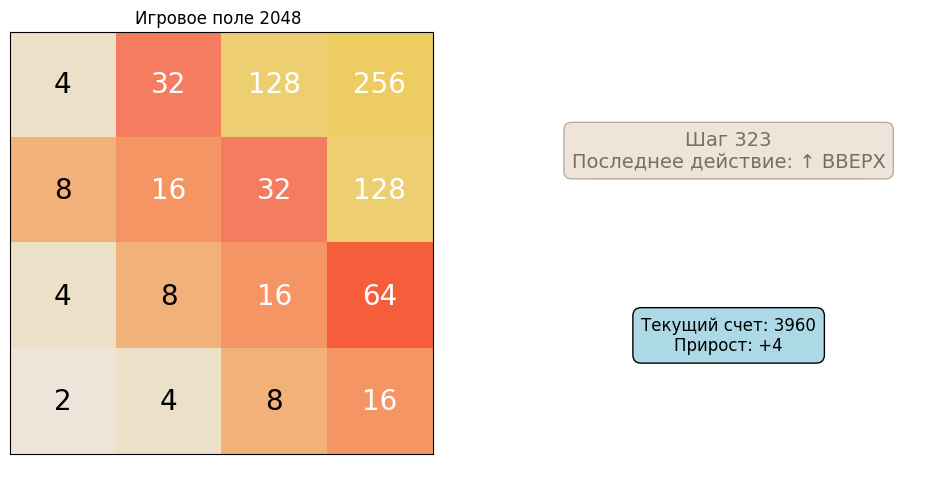


===== Финал =====
Игра завершена (ходов сыграно: 324)
Итоговый счёт: 3960


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


2336.48


In [87]:
env = gym.make(ENV_ID)
def my_formula(f: dict, action: int):
    r, n = f.raw, f.norm   
    to_add = n['smoothness'] if n['tile_sum'] >= 0 else n['edge_occupancy'] 
    return (
        1576.155
        - 108.799 * abs(n['second_max_tile']) 
        - 76.596 * (n['max_tile'] - n['conv_vert_gradient']) 
        + 119.501 * to_add
    )
    
agent = FormulaAgent(
    env,
    feature_list=features_narrow,
    formula=my_formula,
    data=features_expanded
)
run_episode(env, agent)

scores = []
for _ in tqdm(range(100)):
    agent = FormulaAgent(env, formula=my_formula, data=features_expanded, feature_list=features_narrow)
    score = run_episode(env, agent, visualize=False)
    scores.append(score)
    
print(np.mean(scores))

## Symbolic regression

### обучение отдельно для трех ситуаций по сложности на доске (easy, medium, hard)

In [ ]:
model = PySRRegressor(
    niterations=300,
    population_size=500,
    populations=50, 
    maxsize=15,  
    maxdepth=8,
    parsimony=1e-3,
    binary_operators=["+", "-", "*", "/", "max", "min", "cond"],
    unary_operators=["abs","neg"],
    elementwise_loss="L2DistLoss()",
    model_selection="best",
    random_state=42,
    verbosity=1,
    turbo=False, 
    warm_start=True, 
    batching=True,
    batch_size=2500
)

model.fit(features_expanded_easy, target_expanded_easy)

Compiling Julia backend...
[ Info: Started!



Expressions evaluated per second: 8.640e+02
Progress: 2 / 15000 total iterations (0.013%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           8.434e+03  0.000e+00  y = 1307.3
3           8.283e+03  8.547e-03  y = 1316.5 + x₁₃
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 8.300e+03
Progress: 31 / 15000 total iterations (0.207%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       

[ Info: Final population:
[ Info: Results saved to:


  - outputs\20250615_205841_RcKiYQ\hall_of_fame.csv


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          1308.9436   
	1        0.010695                                    x13 + 1311.0717   
	2  >>>>  0.509042                    -1842.897 / min(-1.3114711, x2)   
	3        0.002456            (-1842.7618 / min(-1.3112868, x2)) - x0   
	4        0.061828  (-1750.1311 / min(x2, -1.2635344)) + (x6 * -46...   
	5        0.000349  abs((x6 * 49.42478) + (1743.0331 / min(x2, -1....   
	6        0.046136  (-1630.2723 / min(x2, -1.2232025)) + (min(x0, ...   
	7        0.009913  -1840.5817 / min(min(cond(x6 - (x4 / 1.3484468...   
	8        0.003616  -1840.5817 / min(min(cond(x6 - min(0.8939473, ...   
	
	        loss  complexity  
	0  8431.7290           1  
	1  8253.2830           3  
	2  2981.7988           5  
	3  2967.1904           7  
	4  2622.0603           9  
	5  2621.1465          10  
	6  2502.9644          11  
	7  2453.8274          13  
	8  2436.1477          15  
]

In [14]:
best_equation = model.get_best()
print("Лучшее уравнение (строка):", best_equation['equation'])
print("Лучшее уравнение (sympy):", model.sympy())

Лучшее уравнение (строка): -1842.897 / min(-1.3114711, x2)
Лучшее уравнение (sympy): -1842.897*Piecewise((-0.76250250577386, x2 > -1.3114711), (1/x2, True))


In [16]:
all_eqs = model.equations_
top5_overall = all_eqs.sort_values('loss').head(5)
with pd.option_context('display.max_colwidth', None):
    display(top5_overall[['complexity', 'loss', 'equation']])

complexity       loss  \
8          15  2436.1477   
7          13  2453.8274   
6          11  2502.9644   
5          10  2621.1465   
4           9  2622.0603   

                                                                                       equation  
8  -1840.5817 / min(min(cond(x6 - min(0.8939473, x4 / 1.3484468), -1.3940691), x2), -1.2844385)  
7                -1840.5817 / min(min(cond(x6 - (x4 / 1.3484468), -1.3940691), x2), -1.2844385)  
6                               (-1630.2723 / min(x2, -1.2232025)) + (min(x0, x6) * -107.60238)  
5                                      abs((x6 * 49.42478) + (1743.0331 / min(x2, -1.2611076)))  
4                                        (-1750.1311 / min(x2, -1.2635344)) + (x6 * -46.019882)

In [17]:
model = PySRRegressor(
    niterations=300,
    population_size=500,
    populations=50, 
    maxsize=15,  
    maxdepth=8,
    parsimony=1e-3,
    binary_operators=["+", "-", "*", "/", "max", "min", "cond"],
    unary_operators=["abs","neg"],
    elementwise_loss="L2DistLoss()",
    model_selection="best",
    random_state=42,
    verbosity=1,
    turbo=False, 
    warm_start=True, 
    batching=True,
    batch_size=2500
)

model.fit(features_expanded_medium, target_expanded_medium)

[ Info: Started!



Expressions evaluated per second: 6.990e+01
Progress: 1 / 15000 total iterations (0.007%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.017e+04  0.000e+00  y = 1440.4
3           4.016e+04  -0.000e+00  y = x₁₀ + 1440.8
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 1.630e+03
Progress: 18 / 15000 total iterations (0.120%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss      

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	   pick         score                                           equation  \
	0        0.000000e+00                                           1441.719   
	1        1.832237e-03                                     1441.6052 - x6   
	2        1.227097e-01                    1529.4758 - cond(x6, 188.61452)   
	3        2.242168e-02             ((x11 - x6) / 0.013326512) + 1423.4808   
	4        5.448158e-02          1501.5245 - cond(x6, abs(x7 * 194.62387))   
	5        9.761315e-02  cond(x6, -196.88342) - (cond(x11, -160.19843) ...   
	6        1.166603e-07  abs((cond(x11, -160.19843) - cond(x6, -196.883...   
	7  >>>>  1.386356e-01  ((min(x7, x13) * 126.37552) - cond(x6, 198.542...   
	8        2.392079e-02  ((min(x7, x4 + x13) * 115.15962) - cond(x6, 27...   
	9        1.563664e-02  ((min(max(x13, x4) + x4, x7) * 137.61253) + 16...   
	
	        loss  complexity  
	0  40170.117           1  
	1  40023.184           3  
	2  31313.191           5  
	3  29940.021           7  
	4  28352.480           8  
	5  25715.691           9  
	6  25715.688          10  
	7  22386.668          11  
	8  21340.870          13  
	9  20683.799          15  
]

  - outputs\20250615_213528_rLxCyX\hall_of_fame.csv


In [18]:
best_equation = model.get_best()
print("Лучшее уравнение (строка):", best_equation['equation'])
print("Лучшее уравнение (sympy):", model.sympy())

Лучшее уравнение (строка): ((min(x7, x13) * 126.37552) - cond(x6, 198.54242)) + 1610.4789
Лучшее уравнение (sympy): -Piecewise((198.54242, x6 > 0), (0.0, True)) + Piecewise((x7, x13 > x7), (x13, True))*126.37552 + 1610.4789


In [19]:
all_eqs = model.equations_
top5_overall = all_eqs.sort_values('loss').head(5)
with pd.option_context('display.max_colwidth', None):
    display(top5_overall[['complexity', 'loss', 'equation']])

complexity       loss  \
9          15  20683.799   
8          13  21340.870   
7          11  22386.668   
6          10  25715.688   
5           9  25715.691   

                                                                       equation  
9  ((min(max(x13, x4) + x4, x7) * 137.61253) + 1694.4141) - cond(x6, 290.59906)  
8           ((min(x7, x4 + x13) * 115.15962) - cond(x6, 279.85965)) + 1683.1917  
7                ((min(x7, x13) * 126.37552) - cond(x6, 198.54242)) + 1610.4789  
6               abs((cond(x11, -160.19843) - cond(x6, -196.88342)) + -1424.935)  
5                   cond(x6, -196.88342) - (cond(x11, -160.19843) + -1425.0039)

In [21]:
model = PySRRegressor(
    niterations=300,
    population_size=500,
    populations=50, 
    maxsize=15,  
    maxdepth=8,
    parsimony=1e-3,
    binary_operators=["+", "-", "*", "/", "max", "min", "cond"],
    unary_operators=["abs","neg"],
    elementwise_loss="L2DistLoss()",
    model_selection="best",
    random_state=42,
    verbosity=1,
    turbo=False, 
    warm_start=True, 
    batching=True,
    batch_size=2500
)

model.fit(features_expanded_hard, target_expanded_hard)

[ Info: Started!



Expressions evaluated per second: 5.320e+01
Progress: 1 / 15000 total iterations (0.007%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.388e+05  0.000e+00  y = 1453.1
3           1.384e+05  -0.000e+00  y = x₇ - -1453.2
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 1.670e+03
Progress: 25 / 15000 total iterations (0.167%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss      

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          1454.0709   
	1         0.001443                                     x7 + 1454.4088   
	2   >>>>  0.253010                        (x7 * 276.24454) + 1543.915   
	3         0.032377              ((x7 * x5) * -295.72018) - -1537.5297   
	4         0.019397          ((abs(x9) - x7) + -8.297523) * -201.57361   
	5         0.114097  cond(x6, (x7 * 259.52527) + -279.41748) + 1743...   
	6         0.001650  (abs(x7 - cond(x6, 1.6957005)) * -249.69835) +...   
	7         0.087289  ((min(x7, x2) * 279.49677) + cond(x6, -448.743...   
	8         0.014620  (max(abs(x2), cond(x6, 1.6930846) - x7) * -267...   
	9         0.027902  (cond(x6, -312.61362) + ((min(x13, x7) * x5) *...   
	10        0.006768  (cond(x6, -326.6919) + 1791.9962) + (min(neg(x...   
	11        0.031384  cond(x6, -307.47653) + (((min(x7, x13) * -261....   
	
	          loss  complexity  
	0   138824.280           1  
	1   138424.160           3  
	2    83454.580           5  
	3    78221.875           7  
	4    76719.240           8  
	5    68446.695           9  
	6    68333.820          10  
	7    62621.960          11  
	8    61713.070          12  
	9    60014.973          13  
	10   59610.180          14  
	11   57768.434          15  
]

In [24]:
best_equation = model.get_best()
print("Лучшее уравнение (строка):", best_equation['equation'])
print("Лучшее уравнение (sympy):", model.sympy())

Лучшее уравнение (строка): (x7 * 276.24454) + 1543.915
Лучшее уравнение (sympy): x7*276.24454 + 1543.915


In [25]:
all_eqs = model.equations_
top5_overall = all_eqs.sort_values('loss').head(5)
with pd.option_context('display.max_colwidth', None):
    display(top5_overall[['complexity', 'loss', 'equation']])

complexity       loss  \
11          15  57768.434   
10          14  59610.180   
9           13  60014.973   
8           12  61713.070   
7           11  62621.960   

                                                                                    equation  
11  cond(x6, -307.47653) + (((min(x7, x13) * -261.15213) * min(-0.7668048, x5)) + 1785.1315)  
10                  (cond(x6, -326.6919) + 1791.9962) + (min(neg(x7 * x5), x13) * 270.46826)  
9                     (cond(x6, -312.61362) + ((min(x13, x7) * x5) * -270.2794)) + 1774.4513  
8                          (max(abs(x2), cond(x6, 1.6930846) - x7) * -267.47546) + 1933.1766  
7                              ((min(x7, x2) * 279.49677) + cond(x6, -448.7439)) + 1931.4337

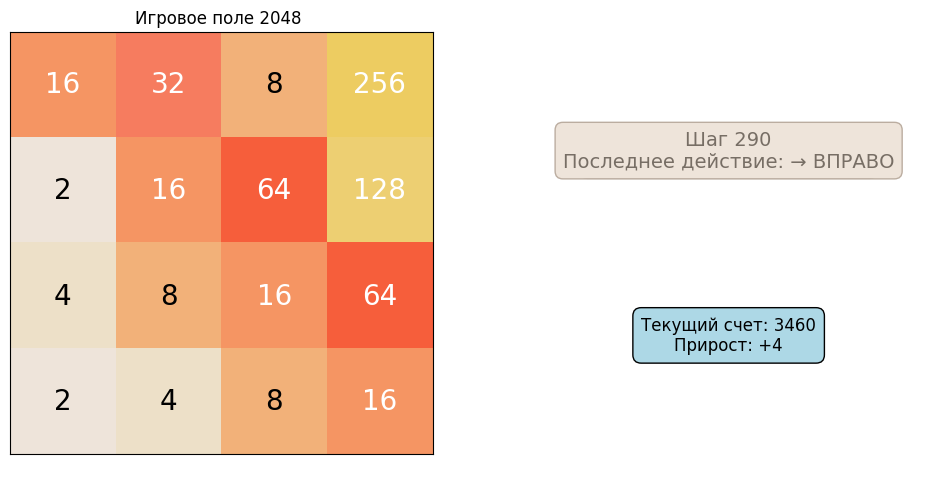


===== Финал =====
Игра завершена (ходов сыграно: 291)
Итоговый счёт: 3460


100%|██████████| 100/100 [00:24<00:00,  4.12it/s]


2480.44


In [38]:
env = gym.make(ENV_ID)

def my_formula(f: dict, action: int) -> float:
    r, n = f.raw, f.norm     
    # пример: предпочитаем гладкость и заполненность
    if r['num_empty'] >= 8:
        return -1842.897 / min(-1.3114711, n['tile_sum'])
    elif r['num_empty'] < 8 and r['num_empty'] >= 4:
        to_add = 198.5424 if n['max_tile'] > 0 else 0
        return (min(n['smoothness'], n['entropy']) * 126.37552) - to_add + 1610.4789
    elif r['num_empty'] < 4:
        to_add = min(n['smoothness'], action) if n['max_tile'] > 0 else 0
        return (n['smoothness'] * 276.24454) + 1543.915

agent = FormulaAgent(env, formula=my_formula, data=features_expanded, feature_list=features_narrow)
score = run_episode(env,agent)

scores = []
for _ in tqdm(range(100)):
    agent = FormulaAgent(env, formula=my_formula, data=features_expanded, feature_list=features_narrow)
    score = run_episode(env, agent, visualize=False)
    scores.append(score)
    
print(np.mean(scores))

### многоклассовый подход

In [30]:
model = PySRRegressor(
    niterations=300,
    population_size=500,
    populations=50, 
    maxsize=15,  
    maxdepth=8,
    parsimony=1e-3,
    binary_operators=["+", "-", "*", "/", "max", "min", "cond"],
    unary_operators=["abs","neg"],
    elementwise_loss="L2DistLoss()",
    model_selection="best",
    random_state=42,
    verbosity=1,
    turbo=False, 
    warm_start=True, 
    batching=True,
    batch_size=2500
)

model.fit(features_expanded, target_expanded)

[ Info: Started!



Expressions evaluated per second: 4.330e+01
Progress: 1 / 15000 total iterations (0.007%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           8.658e+04  0.000e+00  y = 1445.1
3           8.637e+04  -0.000e+00  y = x₁₁ + 1445.3
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 2.440e+02
Progress: 4 / 15000 total iterations (0.027%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          1438.1211   
	1         0.001214                                    x11 + 1438.1278   
	2         0.083483                   cond(x11, 237.74965) + 1294.2079   
	3         0.043406                    1593.6626 - abs(x7 * 201.88184)   
	4         0.128193             (cond(x2, x7) * 245.20663) - -1499.062   
	5         0.036819         ((abs(x7) + x6) * -147.15987) - -1551.5865   
	6   >>>>  0.173011        10954.817 / (6.8271756 - min(x13, x7 - x6))   
	7         0.011219   (max(neg(x7) + x2, x5) * -171.6839) - -1607.0116   
	8         0.100162  -6830.028 / ((min(x2, x7) - cond(x6, 1.2619754...   
	9         0.019264  -7197.3057 / ((min(x7, x2) - max(cond(x6, 1.22...   
	10        0.010005  7005.719 / (3.56041 - min(x9, min(x7, x2) - ma...   
	
	         loss  complexity  
	0   86530.984           1  
	1   86321.060           3  
	2   73047.260           5  
	3   69944.414           6  
	4   61528.950           7  
	5   59304.690           8  
	6   49882.832           9  
	7   49326.340          10  
	8   44625.090          11  
	9   42938.516          13  
	10  42087.832          15  
]

  - outputs\20250616_003357_x8pZbg\hall_of_fame.csv


In [33]:
best_equation = model.get_best()
print("Лучшее уравнение (строка):", best_equation['equation'])
print("Лучшее уравнение (sympy):", model.sympy())

Лучшее уравнение (строка): 10954.817 / (6.8271756 - min(x13, x7 - x6))
Лучшее уравнение (sympy): 10954.817/(6.8271756 - Piecewise((x13, x13 < -x6 + x7), (-x6 + x7, True)))


In [34]:
all_eqs = model.equations_
top5_overall = all_eqs.sort_values('loss').head(5)
with pd.option_context('display.max_colwidth', None):
    display(top5_overall[['complexity', 'loss', 'equation']])

complexity       loss  \
10          15  42087.832   
9           13  42938.516   
8           11  44625.090   
7           10  49326.340   
6            9  49882.832   

                                                                      equation  
10  7005.719 / (3.56041 - min(x9, min(x7, x2) - max(cond(x6, 1.2291912), x2)))  
9        -7197.3057 / ((min(x7, x2) - max(cond(x6, 1.224722), x2)) - 3.704871)  
8                 -6830.028 / ((min(x2, x7) - cond(x6, 1.2619754)) - 3.486027)  
7                             (max(neg(x7) + x2, x5) * -171.6839) - -1607.0116  
6                                  10954.817 / (6.8271756 - min(x13, x7 - x6))

In [35]:
features_narrow[13], features_narrow[7], features_narrow[6]

('entropy', 'smoothness', 'max_tile')

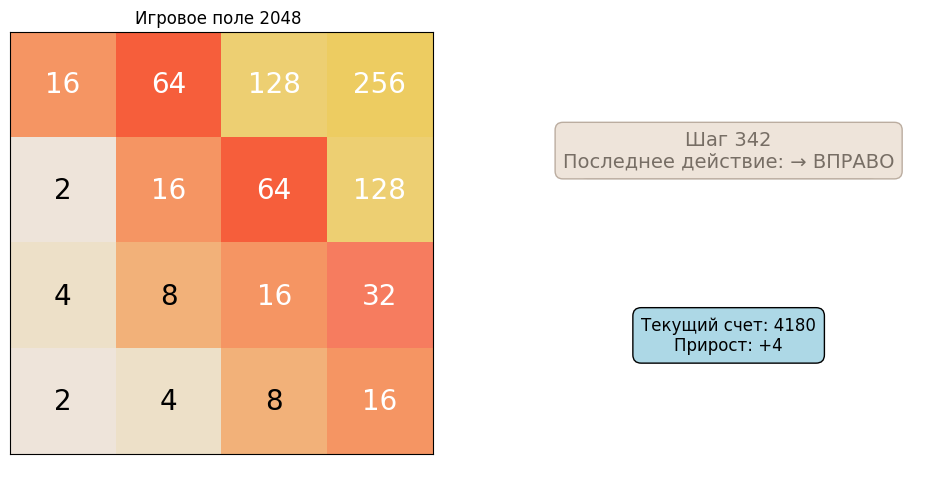


===== Финал =====
Игра завершена (ходов сыграно: 343)
Итоговый счёт: 4180


100%|██████████| 100/100 [00:24<00:00,  4.09it/s]


2347.68


In [39]:
env = gym.make(ENV_ID)
    
def my_formula(f: dict, action: int) -> float:
    r, n = f.raw, f.norm    
    return 10954.817 / (6.8271756 - min(n['entropy'], n['smoothness'] - n['max_tile']))

agent = FormulaAgent(env, formula=my_formula, data=features_expanded, feature_list=features_narrow)
score = run_episode(env,agent)

scores = []
for _ in tqdm(range(100)):
    agent = FormulaAgent(env, formula=my_formula, data=features_expanded, feature_list=features_narrow)
    score = run_episode(env, agent, visualize=False)
    scores.append(score)
    
print(np.mean(scores))

## Генетическое программирование gplearn

In [88]:
cond = make_function(function=lambda x, y, z: np.where(x > 0, y, z), name='cond', arity=3)

### обучение отдельно для трех ситуаций по сложности на доске (easy, medium, hard)

In [ ]:
sr = SymbolicRegressor(
    population_size=500,
    generations=20,
    stopping_criteria=0.01,
    p_crossover=0.5,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.05,
    p_point_mutation=0.1,
    max_samples=0.9,
    function_set=('add', 'sub', 'mul', 'div', 'max', 'min', 'abs', 'neg', cond),
    metric='mean absolute error',   
    parsimony_coefficient=0.1, 
    init_depth=(2, 4),  
    random_state=0,
    verbose=1
)
sr.fit(features_expanded_easy, target_expanded_easy)
print(sr._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.79          1311.94       28          1259.87          1257.55     17.03s
   1    13.20          1307.42       13          1224.82          1226.94     12.98s
   2    20.34          1335.79       40          1105.67          1110.44     19.13s
   3    20.31          1748.08       13          1090.72          1093.34     26.08s
   4    28.81          3097.38       21          1051.63          1055.39     21.91s
   5    20.93          6336.26       17          992.335          1008.93     18.76s
   6    17.98          6433.05       21          948.879          949.264     19.53s
   7    20.76          3761.92       19          765.424           709.41     21.58s
   8    20.63          6426.19       19          754.633          806.529  

In [ ]:
sr = SymbolicRegressor(
    population_size=500,
    generations=20,
    stopping_criteria=0.01,
    p_crossover=0.5,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.05,
    p_point_mutation=0.1,
    max_samples=0.9,
    function_set=('add', 'sub', 'mul', 'div', 'max', 'min', 'abs', 'neg', cond),
    metric='mean absolute error',   
    parsimony_coefficient=0.1, 
    init_depth=(2, 4), 
    random_state=0,
    verbose=1
)
sr.fit(features_expanded_medium, target_expanded_medium)
print(sr._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.79           1442.3       21          1418.37          1421.97      2.10m
   1     9.17          1438.94       35          1408.63          1409.14      1.95m
   2    15.73           1518.2       18          1371.62          1365.88      2.43m
   3    21.58           1510.4       20          1350.98          1350.59      2.15m
   4    19.44          1523.08       18          1304.71          1301.12      2.21m
   5    22.38          2262.97       25          1223.59          1227.79      2.18m
   6    21.73          1918.79       39           924.96          925.041      2.27m
   7    26.58          1975.58       40           836.14           835.64      2.26m
   8    34.48           2456.4       64          763.329          766.721  

In [ ]:
sr = SymbolicRegressor(
    population_size=500,
    generations=20,
    stopping_criteria=0.01,
    p_crossover=0.5,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.05,
    p_point_mutation=0.1,
    max_samples=0.9,
    function_set=('add', 'sub', 'mul', 'div', 'max', 'min', 'abs', 'neg', cond),
    metric='mean absolute error',  
    parsimony_coefficient=0.1, 
    init_depth=(2, 4),   
    random_state=0,
    verbose=1
)
sr.fit(features_expanded_hard, target_expanded_hard)
print(sr._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.79          1454.89       21          1416.54          1415.97      1.64m
   1     8.99          1450.68       13          1339.65          1337.96      1.61m
   2    15.36          1476.74       13          1339.37           1340.5      1.86m
   3    16.27           1652.8       13          1300.91          1304.66      2.12m
   4    12.81          1778.17       13          1300.63          1307.25      1.83m
   5    12.63           3776.3       17          1230.02          1238.68      1.79m
   6    12.66          2097.82       13          996.225          995.554      1.55m
   7    15.16          5318.14       17          994.869          1007.76      1.66m
   8    16.27          12882.9       13          994.907          1007.41  

In [95]:
for i, f in enumerate(features_narrow):
    print(i, f)

0 snake_weighted_sum
1 monotonicity
2 tile_sum
3 potential_merges
4 corner_weighted_sum
5 num_empty
6 max_tile
7 smoothness
8 corner_sum
9 second_max_tile
10 edge_occupancy
11 conv_vert_gradient
12 conv_horiz_gradient
13 entropy


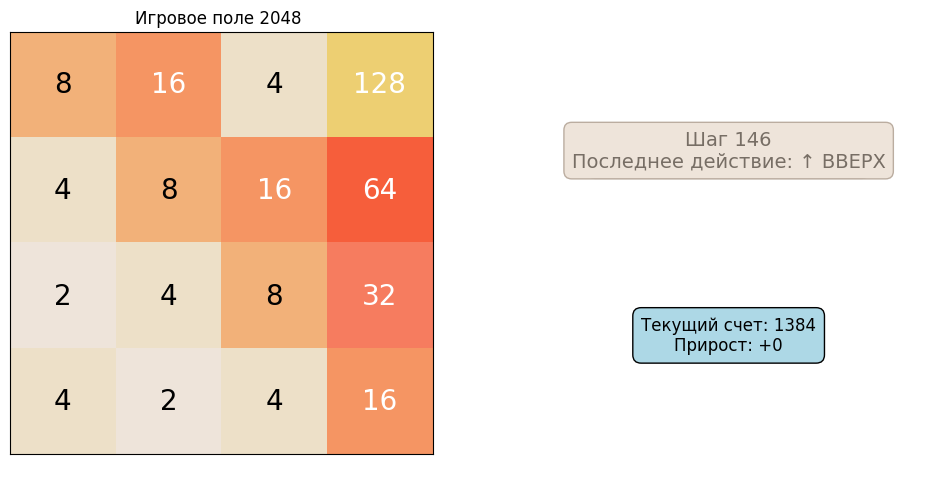


===== Финал =====
Игра завершена (ходов сыграно: 147)
Итоговый счёт: 1384


100%|██████████| 100/100 [00:27<00:00,  3.64it/s]


2180.72


In [97]:
env = gym.make(ENV_ID)
    
def my_formula(f: dict, action: int) -> float:
    r, n = f.raw, f.norm    
    # пример: предпочитаем гладкость и заполненность
    if r['num_empty'] >= 8:
        return (n['second_max_tile'] ** 3 * (0.616 / n['corner_weighted_sum'] - n['num_empty'])) / 0.315 ** 2
    
    elif r['num_empty'] < 8 and r['num_empty'] >= 4:
        if n['corner_weighted_sum'] > 0:
            to_add = - n['num_empty']
        elif n['corner_weighted_sum'] < 0 and n['conv_vert_gradient'] > 0:
            to_add = n['snake_weighted_sum']
        else:
            to_add = n['corner_weighted_sum']
            
        return to_add + 19.14 / abs(n['snake_weighted_sum']) + max(
            abs(to_add) 
            + 2.106 / abs(n['snake_weighted_sum'] * n['monotonicity']) 
            + 246.2 / abs(n['snake_weighted_sum'])
            + abs(
                0.03751 * n['snake_weighted_sum'] 
                + n['snake_weighted_sum'] * 2.106 / abs(n['snake_weighted_sum'] * n['monotonicity'])
                + 56.13 / n['snake_weighted_sum'] 
                + 0.03751 * n['snake_weighted_sum'] ** 3
            ), 
            19.14 / n['snake_weighted_sum'] ** 2
        )

    elif r['num_empty'] < 4:
        return abs((-0.441 / n['second_max_tile']) / (0.110 * n['second_max_tile']))
        

agent = FormulaAgent(env, formula=my_formula, data=features_expanded, feature_list=features_narrow)
score = run_episode(env,agent)

scores = []
for _ in tqdm(range(100)):
    agent = FormulaAgent(env, formula=my_formula, data=features_expanded, feature_list=features_narrow)
    score = run_episode(env, agent, visualize=False)
    scores.append(score)
    
print(np.mean(scores))

### многоклассовый подход

In [90]:
sr = SymbolicRegressor(
    population_size=500,
    generations=20,
    stopping_criteria=0.01,
    p_crossover=0.5,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.05,
    p_point_mutation=0.1,
    max_samples=0.9,
    function_set=('add', 'sub', 'mul', 'div', 'max', 'min', 'abs', 'neg', cond),
    metric='mean absolute error',           # более простое metric может способствовать выбросу коротких формул
    parsimony_coefficient=0.1,            # увеличиваем штраф за длину формулы
    init_depth=(2, 4),                    # начальная глубина деревьев от 2 до 4
    random_state=0,
    verbose=1
)
sr.fit(features_expanded, target_expanded)
print(sr._program)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.79           1438.9       21          1410.52          1411.15      4.95m
   1     9.36          1435.27       13          1360.85          1363.78      4.09m
   2    15.68          1442.16       18          1360.53          1361.78      4.96m
   3    19.57           1446.7       23           1335.9          1336.09      5.52m
   4    14.86          1491.82       13          1269.67          1270.03      5.69m
   5    17.91          2697.04       13          1269.59          1270.71      5.72m
   6    21.84           3280.9       25          1234.31          1232.99      6.62m
   7    17.32          3667.69       13          1070.12          1066.73      8.23m
   8    20.29          5330.05       13          1069.36           1073.6  

In [73]:
for i, f in enumerate(features_narrow):
    print(i, f)

0 snake_weighted_sum
1 monotonicity
2 tile_sum
3 potential_merges
4 corner_weighted_sum
5 num_empty
6 max_tile
7 smoothness
8 corner_sum
9 second_max_tile
10 edge_occupancy
11 conv_vert_gradient
12 conv_horiz_gradient
13 entropy


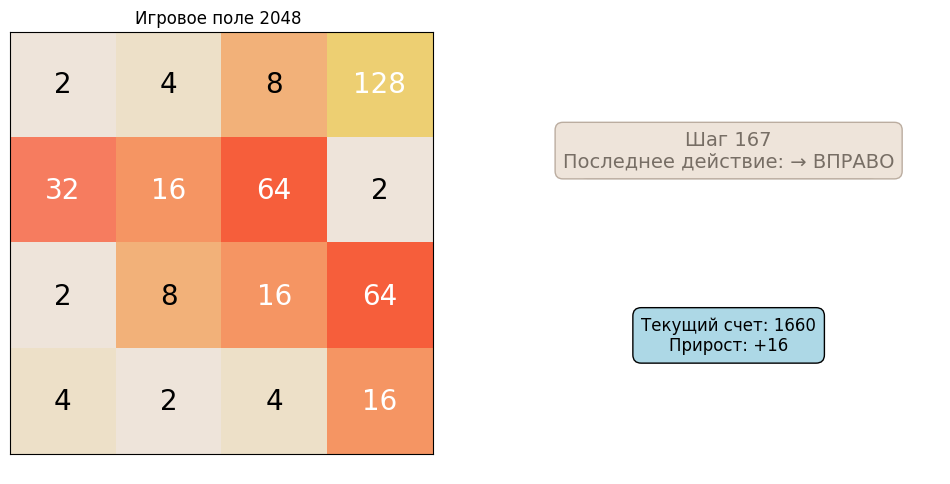


===== Финал =====
Игра завершена (ходов сыграно: 168)
Итоговый счёт: 1660


100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


2335.48


In [91]:
env = gym.make(ENV_ID)
    
def my_formula(f: dict, action: int) -> float:
    r, n = f.raw, f.norm    
    # Общий "делитель" для терминов:
    div_inner = abs(n['snake_weighted_sum']) / max(n['second_max_tile'] * n['second_max_tile'], (-0.441 / n['second_max_tile']) / 0.341)

    # Термины из исходного max-выражения:
    num1 = -0.441 / n['second_max_tile']
    den1 = max(n['second_max_tile'] * n['second_max_tile'], -0.718 / 0.341)
    term1 = abs(num1) / den1

    num2 = -0.718/0.341
    den2 = n['snake_weighted_sum'] * n['snake_weighted_sum'] * abs(div_inner)
    term2 = abs(num2 / den2)

    num3 = -0.718/0.341
    den3 = n['snake_weighted_sum'] * n['snake_weighted_sum'] * n['snake_weighted_sum'] * div_inner
    term3 = abs(num3 / den3)

    return max(term1, term2, term3)
        

agent = FormulaAgent(env, formula=my_formula, data=features_expanded, feature_list=features_narrow)
score = run_episode(env,agent)

scores = []
for _ in tqdm(range(100)):
    agent = FormulaAgent(env, formula=my_formula, data=features_expanded, feature_list=features_narrow)
    score = run_episode(env, agent, visualize=False)
    scores.append(score)
    
print(np.mean(scores))